# Friction term - what is correct friction?


### How we deal with friction in the GPU Ocean in theory

In the shallow-water equations (SWEs), we have source terms on the right hand side represented by the bed friction source term $H(Q)$ and any other source terms $S(Q)$.
The semi-discrete SWEs are then given by 
\begin{equation}
    \begin{split}
    \frac{dQ_{i,j}}{dt} &=  - \frac{1}{\Delta x}[F_{i+1/2, j} - F_{i-1/2,j}] - \frac{1}{\Delta y}[G_{i, j+1/2} - G_{i, j-1/2}] + H(Q_{i,j}) + S(Q_{i,j})\\
                    &=  R(Q)_{i,j} + H(Q_{i,j}).
    \end{split}
\end{equation}

The way that we solve these in GPU Ocean is through using a semi-implicit  discretization. Here, we approximate the time-discretized friction source term by computing it from both next and current solution as follows:
\begin{equation}
    \begin{split}
    H(Q_{i,j}^\star) &\approx Q_{i,j}^\star \tilde{H}(Q_{i,j}^n), \\
    H(Q_{i,j}^{n+1}) &\approx Q_{i,j}^{n+1} \tilde{H}(Q_{i,j}^\star). 
    \end{split}
\end{equation}
The 2nd order Runge-Kutta scheme then becomes:
\begin{equation}
    \begin{split}
    Q_{i,j}^\star &= \frac{ Q_{i,j}^n + \Delta t R(Q^n)_{i,j} }{ 1 - \Delta t \tilde{H}(Q_{i,j}^n) }, \\
    Q_{i,j}^{n+1} &= \frac{ \frac{1}{2}Q_{i,j}^n + \frac{1}{2}\left[ Q_{i,j}^\star + \Delta t R(Q^\star)_{i,j} \right] }{ 1 - \frac{1}{2}\Delta t \tilde{H}(Q_{i,j}^\star) }.
   \end{split}
\end{equation}
Here we note the following:
1) We recover the usual TVD 2nd order Runge-Kutta scheme if $H$ (and thereby also $\tilde{H}$) is zero.
1) If we use the 1st order Runge-Kutta scheme (forward Euler), we simply set $Q^{n+1}_{i,j} = Q^{\star}_{i,j}$ and use only the first equation.
1) The implemented 3rd order Runge-Kutta scheme does not deal with friction at all.
1) Since (as we are going to see) there have been some misprints related to the signs in the semi-implicit Runge-Kutta scheme, we will write out the forward Euler stepping here (discarding spatial indices $i,j$):
\begin{equation}
    \begin{split}
    \frac{dQ}{dt}  &=  R(Q) + H(Q) \\
    \rightarrow \frac{Q^{n+1} - Q^{n}}{\Delta t} &= R(Q^n) + Q^{n+1}\tilde{H}(Q^n) \\
    \rightarrow Q^{n+1} - \Delta t Q^{n+1}\tilde{H}(Q^n) &= Q^n + \Delta t R(Q^n)  \\
    \rightarrow Q^{n+1}  &= [Q^n + \Delta t R(Q^n)] / [1 - \Delta t \tilde{H}(Q^n)]  \\
    \end{split}
\end{equation}
1) The term $\Delta t \tilde{H}(Q)$ should be dimensionless so that the time-stepping makes sense.

### What is the friction source term that is implemented?

Looking at the code (CDKLM kernel), we see that there are two friction terms that are implemented. These expressions are stored in the variable `C` that represents $\Delta t \tilde{H}$ in the above equations. We will furthermore denote the constant variable `FRIC` by $r$.

**Implemented nonlinear flux**

`C = dt_*FRIC*sqrt(u*u+v*v)/h;`
This corresponds to
$$ \tilde{H}(Q) = -r \sqrt{u^2 + v^2}/h \qquad \rightarrow \qquad H(Q) = \left[ \begin{matrix} 0 \\ -r u \sqrt{u^2 + v^2} \\ -r v \sqrt{u^2 + v^2}  \end{matrix}\right] $$

Dimensional analysis requires that $1 = [\Delta t \tilde{H}(Q)] = s [r] (m/s) /m = [r]$, so $r$ should be dimensionless

**Implemented linear flux**

`C = 2.0f*FRIC*dt_/(R[0][j][i] + Hm)`
This corresponds to
$$ \tilde{H}(Q) = -2 r / h \qquad \rightarrow \qquad H(Q) = \left[ \begin{matrix} 0 \\ -2 r u  \\ -2 r v  \end{matrix}\right] $$

Dimensional analysis requires that $1 = [\Delta t \tilde{H}(Q)] = s [r] /m$, meaning that $[r] = m/s$


## What do we do in the literature?

In the following, we will summarize what we say that we do (in both MET and SINTEF) in our three most relevant reference publications.


### The GPU Ocean paper
Brodtkorb and Holm, 2021. Coastal ocean forecasting on the GPU using a two-dimensional finite-volume scheme, Tellus A: Dynamic Meteorology and Oceanography, 73(1), p.1876341 [DOI: 10.1080/16000870.2021.1876341](https://doi.org/10.1080/16000870.2021.1876341)

In eq. (1), we describe the friction source term as
$$
 H(Q) = \left[ \begin{matrix} 0 \\ -r u \sqrt{u^2 + v^2} /h \\ -r v \sqrt{u^2 + v^2}/h \end{matrix} \right],
$$
which should mean that
$$
 \tilde{H}(Q) = \left[ \begin{matrix} 0 \\ -r \sqrt{u^2 + v^2} /h^2 \\ -r \sqrt{u^2 + v^2}/h^2 \end{matrix} \right].
$$
This is not what is implemented, and seems to not make sense.


Furthermore:
* The semi-implicit Runge-Kutta scheme is mentioned in eq (31) in Section 3.5, but with wrong sign in the denominator and sloppy use of notation and the frition is included both in what we here have described as $R$ and $H$.
* Dimensional analysis requires that $1 = [\Delta t \tilde{H}(Q)] = s [r] (m/s)/m^2 = [r]/m$, meaning that $[r] = m$


### The 2012 MET-report from Lars Petter

Lars Petter Røed, *Documentation of simple ocean models for use in ensemble predictions*, [met.no report 3/2013](https://www.met.no/publikasjoner/met-report/met-report-2012)

Combining equations (34) and (35), we get that the friction source term here is
$$
H(Q) = -\frac{R}{H}\mathbf{U} 
= \left[ \begin{matrix} 0 \\ - \frac{R}{H} hu  \\ - \frac{R}{H} hv  \end{matrix}\right] 
\approx \left[ \begin{matrix} 0 \\ - R u  \\ - R v  \end{matrix}\right].
$$
This gives 
$$
\tilde{H}(Q) = \left[ \begin{matrix} 0 \\ - R/h  \\ - R/h  \end{matrix}\right],
$$
assuming $\eta \ll H$.


* This is similar to, but a factor 2 off from, the linear friction term implemented in GPU Ocean. Why the factor 2??
* Dimensional analysis requires that $1 = [\Delta t \tilde{H}(Q)] = s [r] /m$, meaning that $[r] = m/s$.
This is in accordance with the value given in the MET-report ($R = 2.4 \cdot 10^{-3}$ m/s), and in its reference (Martinsen et al, 1979,  lower right panel on page 10 or 1134).



### The Malpasset dam break paper

Brodtkorb, Sætra, Altinakar, *Efficient shallow water simulations on GPUs: Implementation, visualization, verification, and validation*. Comput. Fluids, 55(0):1-12, (2012). DOI: [10.1016/j.compfluid.2011.10.012](https://doi.org/10.1016/j.compfluid.2011.10.012)

In eq. (1), we describe the friction source term as
$$
 H(Q) = \left[ \begin{matrix} 0 \\ -g u \sqrt{u^2 + v^2} / C_z^2 \\ -g v \sqrt{u^2 + v^2}/C_z^2 \end{matrix} \right],
$$
which means that
$$
 \tilde{H}(Q) = \left[ \begin{matrix} 0 \\ -g \sqrt{u^2 + v^2} / (h C_z^2) \\ -g \sqrt{u^2 + v^2}/(h C_z^2) \end{matrix} \right],
$$
as given in  (9) in the paper.

Here, $C_z = h^{1/6}/n$, where $n$ is the manning coefficient. 

* If $r = g/C_z^2$, this is similar to what is implemented in GPU Ocean, although not quite since $C_z$ depends on $h$.
* In their Section 4.2, they use Manning coefficient $n = 0.033 m^{1/3} s$. However, $n$ should have dimension $s/m^{1/3}$ according [Wikipedia](https://en.wikipedia.org/wiki/Manning_formula) and [this paper (see just under eq (4))](https://iopscience.iop.org/article/10.1088/1742-6596/973/1/012032/pdf).
* Using the correct unit $[n] = s/m^{1/3}$, we see that $[C_z] = m^{1/6}/(s/m^{1/3}) = m^{1/6}m^{1/3}/s = m^{1/2}/s$, which again gives correct total unit:
$$[\Delta t \tilde{H}(Q)] = \frac{s (m/s^2) (m/s)}{(m (m^{1/2}/s)^2)} =\frac{ (m/s^2) m}{(m (m/s^2))} = 1 $$
* The semi-implicit Runge-Kutta scheme has the wrong sign in the denuminator.

**What is a typical value for $r = g/C_z^2$?**
First, we see that $r = g n^2 / h^{1/3}$. Using $g = 10$ and $n = 0.033$, we get 
$$ r(h)   \approx 0.01/h^{1/3}.$$

The range $h = [10, 1000]$ corresponds to $r = [0.005, 0.0011]$. In the ensemble runs in the barotropic/baroclinic paper, we use a range for $r = [0, 0.005]$. The values that we have used in the paper is therefore good.

Unit of $[r] = [\frac{g n^2 }{h^{1/3}}] = \frac{m/s^2 (s^2/m^{2/3}) }{ m^{1/3}}= \frac{m}{m^{2/3}m^{1/3}} = 1$.

**What is the concequence of using a nonlinear friction?**
By using the non-linear friction term, we get that the friction along $x$ also depends on $v$, and vica versa. Also, for low and high velocity we get a lower and higher friction, respectively. See plot below. 

0.01089 0.005054690239804316 0.0023461793774447216 0.0010890000000000001 0.0005054690239804317


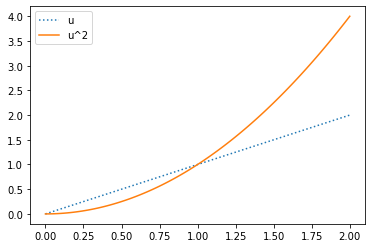

In [51]:
g = 10
n = 0.033
def r(h):
    return g*n*n/h**(1/3)

print(r(1), r(10), r(100), r(1000), r(10000))

from matplotlib import pyplot as plt
import numpy as np
u = np.linspace(0,2, 100)
plt.plot(u, u, ':', label='u')
plt.plot(u, u*u, label='u^2')
plt.legend()



# Conclusion
(This can be used as an appendix in the barotropic/baroclinic paper)

We have utilized a parameterized nonlinear friction source term inspired by the Manning formula, where we have used the parameter $r$ to represent  $n^2 g / h^{1/3}$. Here, $n$is the roughness coefficient with a typical value for $n = 0.033$ (see Brodtkorb et al (2012)). 
Using a range of depth values from $h = 10$ m to $h = 1000$ m, we see that the term that we parameterize by $r$ would be between 0.001 and 0.005. This fits very well with the parameter range we have used in the numerical experiments.

An alternative friction model would be a linear one, where we drop the term $\sqrt{u^2 + v^2}$, meaning that the friction source term becomes $-ru$ and $-rv$ for the momentum along the $x$- and $y$-axis, respectively. The value of $r$ is typically 0.003 (as in the MET report 3/2012, and Martinsen et al (1979)). The consequence would then be that the friction would be the same for velocities close to 1, whereas the friction would be higher and lower for low and high velocities, respectively. Since we in this work use an uncertain coefficient $r$, these differences does not result in conceptual differences.

# Test case for Lofoten

Check the consequence for the Lofoten case using non-linear and linear friction.

Check results at t = 1, 3, 6, 24 hours

In [20]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization

source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

casename = 'lofoten'

case_info = NetCDFInitialization.getCaseLocation(casename)
print(case_info["name"])

data_args = NetCDFInitialization.getInitialConditions(source_url,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], download_data=False)
hours = [1, 3, 6, 24]
print("Default friction with r = "+str(data_args['r']))

lofoten
Default friction with r = 0.003


In [16]:
%cuda_context_handler gpu_ctx

In [32]:
# helper function to run the sim
def stepToHour(sim, hour):
    end_t = hour*3600
    step_t = end_t - sim.t
    sim.step(step_t)
    print("done stepping to "+str(hour)+"h")
    return sim.download(interior_domain_only=True)


## Non-linear friction term

In [33]:
if "nonlinear_sim" in globals():
    nonlinear_sim.cleanUp()
nonlinear_sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args))

nonlinear = []
for h in hours:
    nonlinear.append(stepToHour(nonlinear_sim, h))

print(len(nonlinear))


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


done stepping to 1h
done stepping to 3h
done stepping to 6h
done stepping to 24h
4


## Linear friction term
To run with linear friction term, we need to make a small change in the code:
Line 947 in cdklm_kernel should be changed from 
```
C = dt_*FRIC*sqrt(u*u+v*v)/h;
```
to 
```
C = dt_*FRIC/h;
```

The CDKLM16 class will then recompile the kernel.

In [34]:
if "linear_sim" in globals():
    linear_sim.cleanUp()
linear_sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args))

linear = []
for h in hours:
    linear.append(stepToHour(linear_sim, h))

print(len(linear))


C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:220: UserWarning: The CUDA compiler succeeded, but said the following:
C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\gpu_kernels\CDKLM16_kernel.cu(944): warning: variable "u" was declared but never referenced

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\gpu_kernels\CDKLM16_kernel.cu(945): warning: variable "v" was declared but never referenced

kernel.cu

  jit_compile_args={
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


done stepping to 1h
done stepping to 3h
done stepping to 6h
done stepping to 24h
4


## Plot the differences

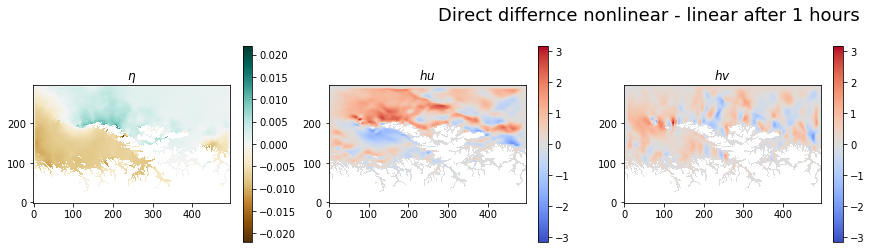

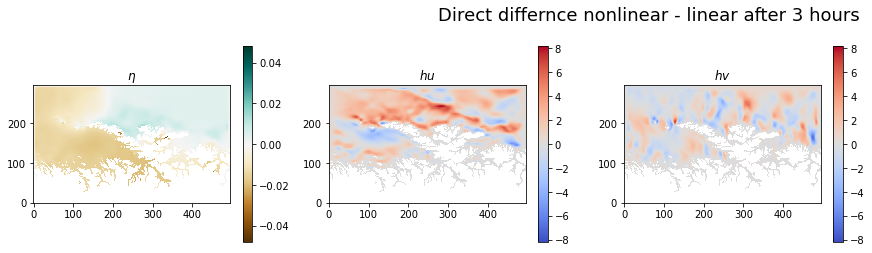

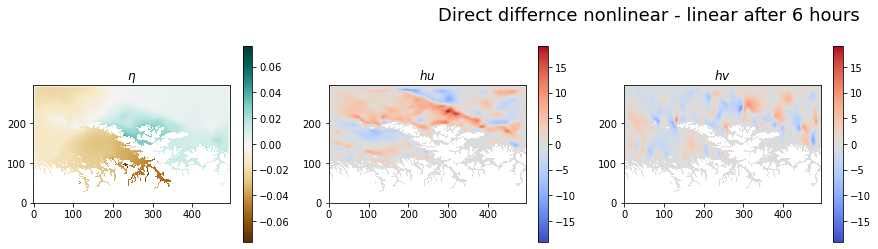

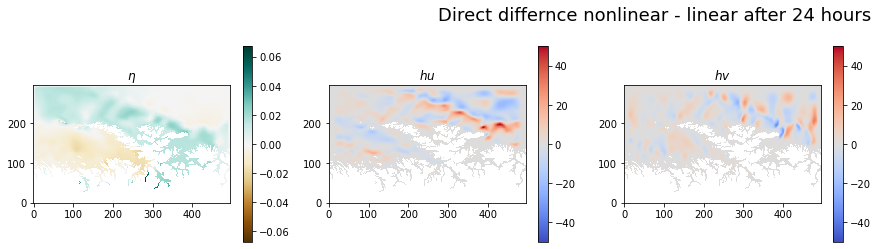

In [45]:
def plot_diffs(nonlinear, linear, hours):

    for i in range(len(hours)):

        eta_diff = nonlinear[i][0] - linear[i][0]
        hu_diff  = nonlinear[i][1] - linear[i][1]
        hv_diff  = nonlinear[i][2] - linear[i][2]

        eta_max = np.max(np.abs(eta_diff))
        hu_max = max(np.max(np.abs(hu_diff)), np.max(np.abs(hv_diff)))

        fig = plt.figure(figsize=(15,4))
        
        fig.suptitle("Direct difference nonlinear - linear after "+str(hours[i])+" hours", 
                 fontsize=18,
                 horizontalalignment='left')

        ax = [None]*3
        sp = [None]*3
        ax[0] = plt.subplot(1, 3, 1)
        sp[0] = ax[0].imshow(eta_diff, interpolation="none", origin='lower', 
                             cmap=plt.cm.BrBG, vmin=-eta_max, vmax=eta_max)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        ax[1] = plt.subplot(1, 3, 2)
        sp[1] = ax[1].imshow(hu_diff, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, vmin=-hu_max, vmax=hu_max)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$hu$")

        ax[2] = plt.subplot(1, 3, 3)
        sp[2] = ax[2].imshow(hv_diff, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, vmin=-hu_max, vmax=hu_max)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$hv$")

plot_diffs(nonlinear, linear, hours)

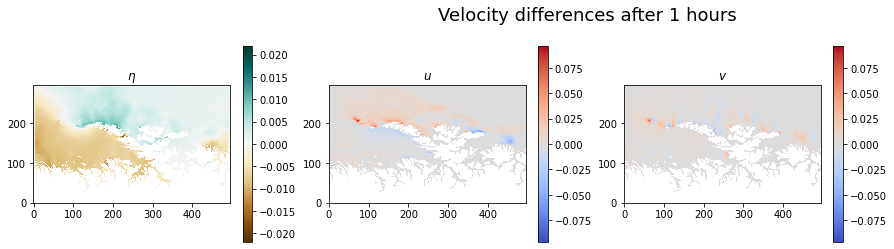

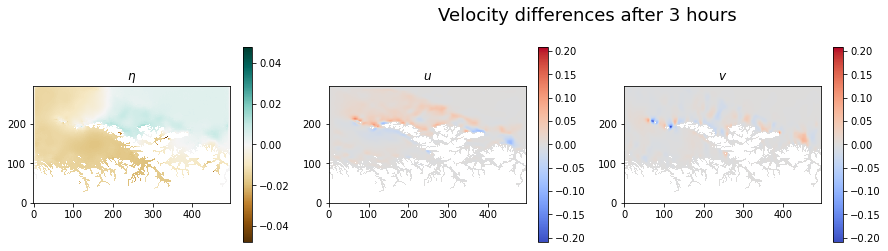

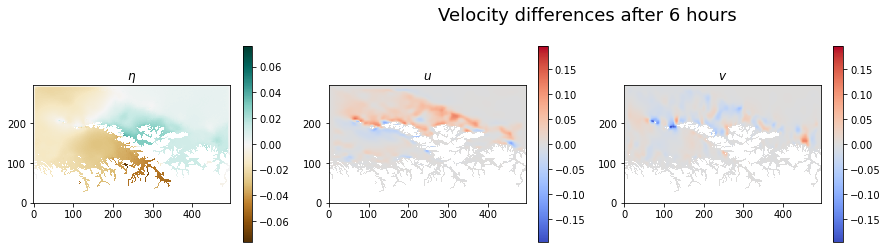

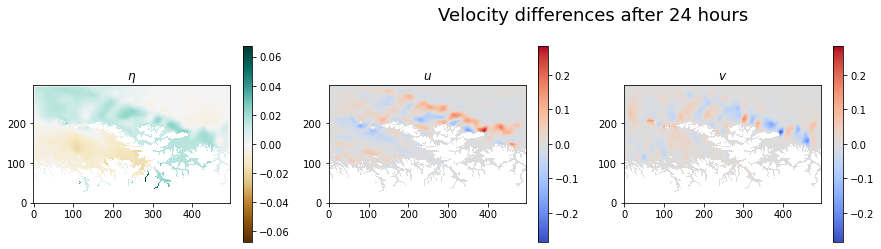

In [49]:
def plot_diffs_vel(nonlinear, linear,  hours, H):

    for i in range(len(hours)):
        def getVels(fields, H):
            u = fields[1]/(H + fields[0])
            v = fields[2]/(H + fields[0])
            return u, v
        u_nonlinear, v_nonlinear = getVels(nonlinear[i], H)
        u_linear, v_linear = getVels(linear[i], H)

        eta_diff = nonlinear[i][0] - linear[i][0]
        u_diff  = u_nonlinear - u_linear
        v_diff  = v_nonlinear - v_linear
        
        eta_max = np.max(np.abs(eta_diff))
        u_max = max(np.max(np.abs(u_diff)), np.max(np.abs(v_diff)))

        fig = plt.figure(figsize=(15,4))
        
        fig.suptitle("Velocity differences after "+str(hours[i])+" hours", 
                 fontsize=18,
                 horizontalalignment='left')

        ax = [None]*3
        sp = [None]*3
        ax[0] = plt.subplot(1, 3, 1)
        sp[0] = ax[0].imshow(eta_diff, interpolation="none", origin='lower', 
                             cmap=plt.cm.BrBG, vmin=-eta_max, vmax=eta_max)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        ax[1] = plt.subplot(1, 3, 2)
        sp[1] = ax[1].imshow(u_diff, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, vmin=-u_max, vmax=u_max)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$u$")

        ax[2] = plt.subplot(1, 3, 3)
        sp[2] = ax[2].imshow(v_diff, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, vmin=-u_max, vmax=u_max)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$v$")

_, H = linear_sim.downloadBathymetry(interior_domain_only=True)
plot_diffs_vel(nonlinear, linear,  hours, H)

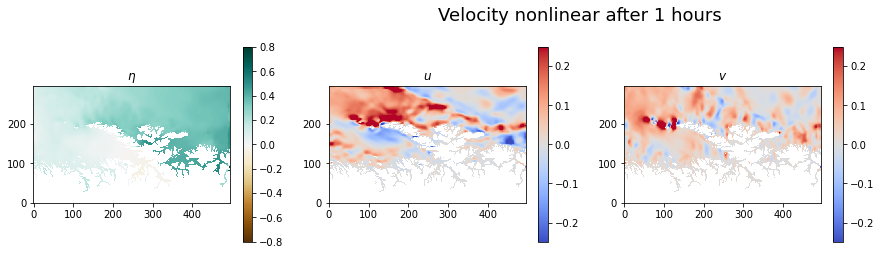

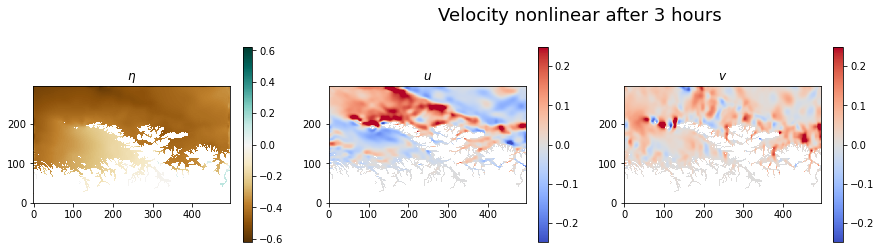

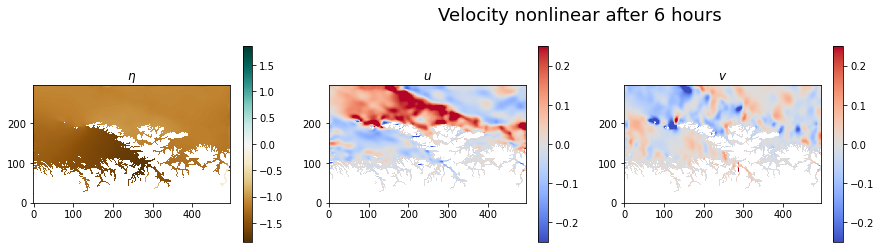

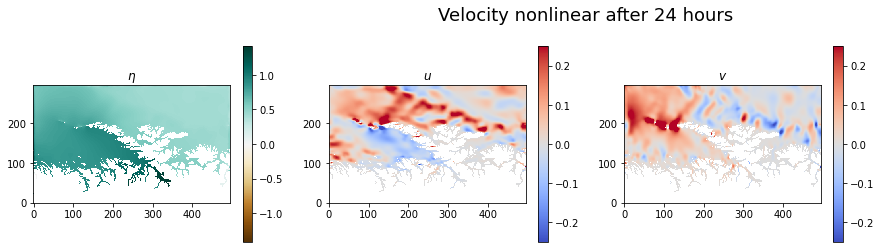

In [52]:
def plot_vels(fields, hours, field_name, H):

    for i in range(len(hours)):
        def getVels(fields, H):
            u = fields[1]/(H + fields[0])
            v = fields[2]/(H + fields[0])
            return u, v
        u, v = getVels(fields[i], H)

        eta = fields[i][0] 

        eta_max = np.max(np.abs(eta))
        #u_max = max(np.max(np.abs(u)), np.max(np.abs(v)))
        u_max = 0.25

        fig = plt.figure(figsize=(15,4))
        
        fig.suptitle("Velocity "+field_name+" after "+str(hours[i])+" hours", 
                 fontsize=18,
                 horizontalalignment='left')

        ax = [None]*3
        sp = [None]*3
        ax[0] = plt.subplot(1, 3, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=plt.cm.BrBG, vmin=-eta_max, vmax=eta_max)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        ax[1] = plt.subplot(1, 3, 2)
        sp[1] = ax[1].imshow(u, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, vmin=-u_max, vmax=u_max)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$u$")

        ax[2] = plt.subplot(1, 3, 3)
        sp[2] = ax[2].imshow(v, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, vmin=-u_max, vmax=u_max)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$v$")

_, H = linear_sim.downloadBathymetry(interior_domain_only=True)
plot_vels(nonlinear, hours,  "nonlinear", H)

(298, 498) (296, 496) (296, 496)
